In [34]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
import seaborn as sns

In [35]:
%pip install ktrain
import ktrain
print('Ktrain Version: ' + ktrain.__version__)

Ktrain Version: 0.37.6


In [36]:
%pip install bokeh
import bokeh
print('Bokeh Version: ' + bokeh.__version__)

Bokeh Version: 3.2.2


In [4]:
%pip install pyarrow

import pyarrow as pa
import pyarrow.parquet as pq

In [37]:
%pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
output_file_parquet = pq.read_table('/content/gdrive/MyDrive/Colab notebooks/NLP/Final project/df_filtered.parquet')
df_relevant_articles = output_file_parquet.to_pandas()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
sample_df = df_relevant_articles.sample(frac=0.7, replace=True, random_state=1)

sample_df.head()

,date,processed_text
128037,2023-01-11,vymo release comprehensive guide sale engageme...
5192,2023-06-28,cvpr reveals top five trend computer vision cv...
50057,2023-05-09,aireview ai assistant validate stay booking pr...
109259,2023-03-08,activefence acquires rewire build next generat...
73349,2023-05-31,china warns artificial intelligence risk call ...


In [9]:
texts = sample_df['processed_text']

### VADER

In [15]:
analyzer = SentimentIntensityAnalyzer()

def label_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    if sentiment_score['compound'] >= 0.05:
        return 'positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'


In [16]:
sample_df['sentiment'] = sample_df['processed_text'].apply(label_sentiment)
sample_df.head()

,date,processed_text,sentiment
128037,2023-01-11,vymo release comprehensive guide sale engageme...,positive
5192,2023-06-28,cvpr reveals top five trend computer vision cv...,positive
50057,2023-05-09,aireview ai assistant validate stay booking pr...,positive
109259,2023-03-08,activefence acquires rewire build next generat...,positive
73349,2023-05-31,china warns artificial intelligence risk call ...,positive


In [23]:
sample_df['sentiment_vader'].value_counts()

positive    104492
negative      5467
neutral        157
Name: sentiment_vader, dtype: int64

In [18]:
sample_df.rename(columns={"sentiment": "sentiment_vader"}, inplace=True)


In [20]:
sample_df.to_parquet('/content/gdrive/MyDrive/Colab notebooks/NLP/Final project/df_vader.parquet', index=False)

### Sentiment analysis overtime

In [7]:
output_file_parquet = pq.read_table('/content/gdrive/MyDrive/Colab notebooks/NLP/Final project/df_vader.parquet')
sample_df = output_file_parquet.to_pandas()


In [8]:
sample_df

,date,processed_text,sentiment_vader
0,2023-01-11,vymo release comprehensive guide sale engageme...,positive
1,2023-06-28,cvpr reveals top five trend computer vision cv...,positive
2,2023-05-09,aireview ai assistant validate stay booking pr...,positive
3,2023-03-08,activefence acquires rewire build next generat...,positive
4,2023-05-31,china warns artificial intelligence risk call ...,positive
...,...,...,...
110111,2023-06-14,europe leading world push regulate ai woodtvco...,positive
110112,2022-10-12,movr announces partnership xtra computer visio...,positive
110113,2021-04-09,artificial intelligence stay let make sure res...,positive
110114,2021-10-18,vodaai announces new product partnership redzo...,positive


In [9]:
sample_df['sentiment_vader'].value_counts()

positive    104492
negative      5467
neutral        157
Name: sentiment_vader, dtype: int64

In [10]:
sample_df['date'] = pd.to_datetime(sample_df['date'])
sample_df['year'] = sample_df['date'].dt.year
sample_df['month'] = sample_df['date'].dt.month

#Drop rows with neutral sentiment
sample_df = sample_df[sample_df.sentiment_vader != 'neutral']

# Group by year, month, and sentiment, and calculate counts
sentiment_counts = sample_df.groupby(['year', 'month', 'sentiment_vader']).size().reset_index(name='count')


In [11]:
sentiment_counts

,year,month,sentiment_vader,count
0,2020,1,negative,85
1,2020,1,positive,1437
2,2020,2,negative,67
3,2020,2,positive,1261
4,2020,3,negative,41
...,...,...,...,...
81,2023,5,positive,9459
82,2023,6,negative,596
83,2023,6,positive,9350
84,2023,7,negative,202


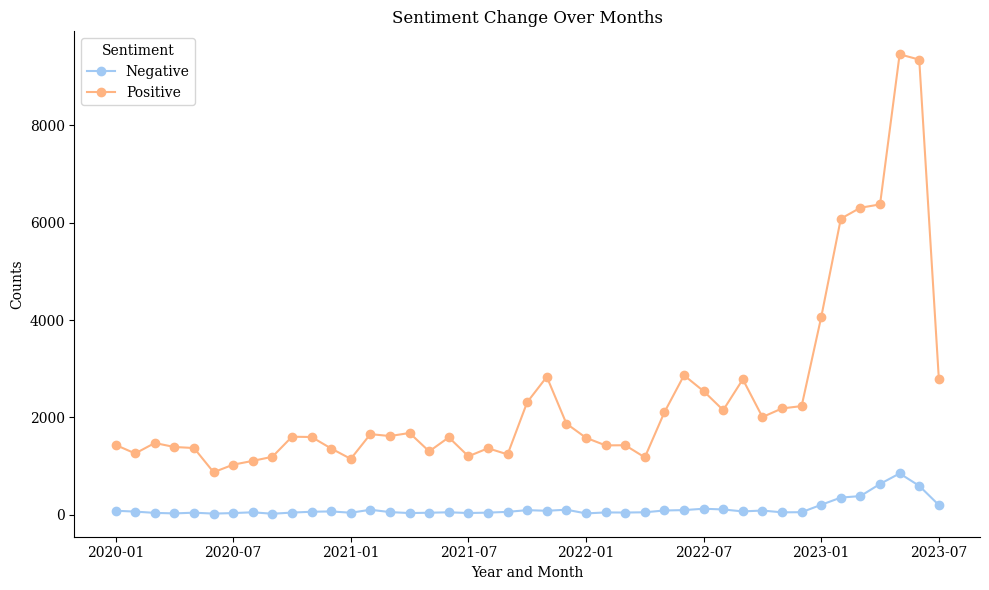

In [12]:
# Pivot the table for plotting
pivot_table = sentiment_counts.pivot_table(index=['year', 'month'], columns='sentiment_vader', values='count', fill_value=0)

#sns.set_palette(["Oranges_r", "Blues_r"])
sns.set_palette("pastel")

plt.figure(figsize=(10, 6))
pivot_table.plot(kind='line', marker='o', linestyle='-', ax=plt.gca())

formatted_xticks = [f'{year}-{month:02}' for year, month in pivot_table.index]
every_other_xtick_idx = range(0, len(formatted_xticks), 6)
plt.xticks(every_other_xtick_idx, [formatted_xticks[i] for i in every_other_xtick_idx])

plt.title("Sentiment Change Over Months")
plt.xlabel("Year and Month")
plt.ylabel("Counts")
plt.legend(title="Sentiment", labels=["Negative", "Positive"])
plt.tight_layout()
sns.despine()
plt.show()

### Certain types of jobs are more likely to be impacted by AI


In [13]:
# List of jobs
jobs_list = [
    'Human Resources','Marketing','Sales','Project','Operations','Financial Analyst','Data Analyst',
    'Software Engineer','Graphic Designer','Content Writer','Customer Service Representative','Account Manager',
    'Business Development Manager','Product Manager','Research Scientist','Quality Assurance Specialist',
    'Operations Coordinator','IT Support Specialist','Administrative Assistant','HR Coordinator',
    'Marketing Coordinator','Sales Representative','Financial Controller','Data Scientist','UX/UI Designer',
    'Web Developer','Systems Administrator','Operations Analyst','Supply Chain Manager','Compliance Officer',
    'Social Media Manager','Public Relations Manager','Event Planner','Logistics Coordinator',
    'Customer Success Manager','Business Analyst','Nurse','Doctor','Pharmacist','Dentist','Teacher',
    'Engineer','Architect','Lawyer','Accountant','Financial Advisor','Researcher','Scientist','Chef',
    'Hotel Manager','Flight Attendant','Photographer','Artist','Real Estate Agent','Retail Store Manager',
    'Operations Supervisor','Customer Support Specialist','Legal Assistant','IT Project Manager','Data Entry Clerk',
    'Warehouse Supervisor','Insurance Agent','Marketing Analyst','Operations Director','HR Director',
    'Financial Planner','Event Coordinator','Social Worker','Physical Therapist','Occupational Therapist',
    'Electrician','Plumber','Construction Manager','Research Assistant','Laboratory Technician','Operations Engineer'
]

In [ ]:
# Create a set of lowercase job keywords for efficient matching
job_keywords = {keyword.lower() for job in jobs_list for keyword in job.lower().split()}

# Create a dictionary to store job counts
job_counts = {job: 0 for job in jobs_list}

# Iterate through the sample DataFrame
for _, row in sample_df.iterrows():
    article = row["processed_text"].lower()
    matched_jobs = [job for job in jobs_list if any(keyword in article for keyword in job.lower().split())]
    for job in matched_jobs:
        job_counts[job] += 1

# Create a new DataFrame from the job counts dictionary
results_df = pd.DataFrame(job_counts.items(), columns=["Job", "Count"])


In [96]:
likely_impacted_jobs = results_df.sort_values(by="Count", ascending=False)
likely_impacted_jobs.head(20)

,Job,Count
58,IT Project Manager,109850
17,IT Support Specialist,109846
12,Business Development Manager,94538
10,Customer Service Representative,88415
35,Business Analyst,87144
64,HR Director,84361
9,Content Writer,83565
23,Data Scientist,83351
6,Data Analyst,82956
59,Data Entry Clerk,81389
